# Objetivos

Objetivo: Determinar los tópicos predominantes en cada conversación del corpus adjunto

Notas:

  - Se adjunta corpus (en formato csv) compuesto por la desgrabación de 640 llamadas
  - Cada desgrabación corresponde a un llamado en el que interviene un cliente y un agente de un contact center

Lineamientos:
  - El lenguaje a utilizar es Python, y se debe entregar una Notebook en donde se puedan visualizar todos los pasos ejecutados, desde la carga del corpus, hasta la predicción de cada conversación realizada por el modelo.
  - Se pueden utilizar las librerías y técnicas que se consideren, no hay limitación en cuanto a este punto.
  - El código deberá ser compartido a través de una cuenta de Git.


## Organización
1. Carga de los documentos del corpus
2. Preprocesamiento de los documentos: tokenización, eliminación de stopwords y signos de puntuación, lematización y filtrado por part-of-speech
3. Entrenamiento de un modelo base de LDA
4. Tuneo de hiperparámetros
5. Posibles caminos para mejorar la performance

# Carga del corpus


In [98]:
import io
import os
from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/corpus'
os.chdir(folder_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from concurrent.futures import ThreadPoolExecutor
import time

csv_files = [file for file in os.listdir() if file.endswith('.csv')]

doc_list = []

def load_csv_file(csv_file):
    file_path = os.path.join(folder_path, csv_file)
    with open(file_path, 'r') as file:
      doc_list.append(file.read())

#Al ser una tarea I/O, usar threading puede acelerar la carga de los archivos
with ThreadPoolExecutor() as executor:
  executor.map(load_csv_file,csv_files)

In [ ]:
print(f"Se cargaron {len(doc_list)} documentos")
doc_list[637]

# Preprocesamiento
- Eliminar stopwords
- Eliminar signos de puntuación
- Lematizar el texto y filtrar por Part-of-speech
- Tokenizar separando en palabras

In [4]:
#Remover "Pregunta\n" de cada texto
doc_list = [text.replace("Pregunta\n ", "") for text in doc_list]

Remover stopwords y signos de puntuación. Lematizar el texto.

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#El lemmatizer de nltk no tiene implementación en español, así que uso el de spacy.
#También uso Spacy para filtrado por part-of-speech, para quedarme solo con sustantivos, verbos y adjetivos
!python -m spacy download es_core_news_sm
import spacy

2023-12-27 16:10:13.178571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 16:10:13.178630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 16:10:13.183510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 16:10:13.202728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 16:10:16.175612: W tensorflow/compiler/tf2

In [7]:
stop = set(stopwords.words('spanish'))
exclude = set(string.punctuation)

In [8]:
print(stop)
print(exclude)

{'tendrías', 'hayas', 'hasta', 'el', 'estada', 'muy', 'seremos', 'seríais', 'ellas', 'tuvimos', 'tendría', 'tenidos', 'tuviera', 'estarás', 'serán', 'habidas', 'estuviese', 'fue', 'tanto', 'era', 'mis', 'esas', 'tuyo', 'tengan', 'estuvierais', 'se', 'tú', 'serías', 'serían', 'hube', 'estoy', 'vuestro', 'estuvieseis', 'tuvisteis', 'con', 'todo', 'teniendo', 'hubisteis', 'sí', 'que', 'tenéis', 'porque', 'muchos', 'hubo', 'tienen', 'algo', 'estuviéramos', 'habríamos', 'habrían', 'han', 'ha', 'mí', 'sea', 'y', 'algunos', 'fueses', 'eso', 'fuerais', 'un', 'estas', 'suyos', 'tendríais', 'otra', 'fuésemos', 'tengas', 'hemos', 'hay', 'estuvimos', 'sobre', 'más', 'míos', 'todos', 'ya', 'otro', 'esa', 'estuvieras', 'habrán', 'me', 'le', 'hubieseis', 'hayáis', 'también', 'hubiesen', 'éramos', 'sentida', 'seré', 'ti', 'habrías', 'hubieses', 'tuvieras', 'uno', 'tenidas', 'tendremos', 'al', 'sentid', 'habréis', 'donde', 'estaré', 'seas', 'fuese', 'sin', 'estará', 'habido', 'vuestras', 'fuera', 'sean

In [9]:
#Cargar el modelo en español
nlp = spacy.load("es_core_news_sm")

def lemmatize_doc(doc):
  doc = nlp(' '.join(doc))
  allowed_pos = ['NOUN', 'VERB', 'ADJ'] #Part-of-speech filtering
  filtered_tokens = [token for token in doc if token.pos_ in allowed_pos]
  lemmatized_tokens = [token.lemma_ for token in filtered_tokens]
  return lemmatized_tokens

In [10]:
def clean(doc):
    stop_free = [i.lower() for i in doc if i not in stop and i not in exclude]
    lemmatized = lemmatize_doc(stop_free)
    return lemmatized

In [11]:
#Tokenización del texto separandolo en palabras
doc_tok = [word_tokenize(doc) for doc in doc_list]

In [12]:
#Limpieza del texto tokenizado: eliminación de stopwords y signos de puntuación, lematización y filtrado por part-of-speech
doc_clean = [clean(doc) for doc in doc_tok]

In [14]:
doc_list[0]

'Hola , mi nombre es Valeria . Disculpe , no escuché tu nombre . José . José , Mira , sabes ? Bueno , estoy constantemente así . No te digo , hay un , pero . tiempo de cuarentena y todo Y ahora con un pedido que recibir ahora que estoy , de hecho guardando tenía fecha de entrega para el lunes y el minuto que llegaron yo salí a comprar entonces rehaciendo porque no lo no , me lo dejaron en conserjería . Y llegó ahora el pedido y perdió la cadena de frío . Entonces hay ciertos productos que yo estoy dejando pasar , porque todavía tienen están como congelador , como carne , pollo . Pero disfrutas que me llegaron con olor . Dinero ? Tengo una , una casa , . Que la frutilla incomible , Tan , tan . Y las también hay . . Plata ya en . igual un poco molesta porque también un salmón salmón . Tampoco congelado . Entonces también peligroso . Y venían las cajas mojadas . Me aseguraron que la no , se perdía por por , digamos , por no haberse entregado el mismo día . Yo me preocupaba de que de que l

In [ ]:
doc_clean[0]

In [16]:
# Ahora doc_Clean es una lista de 640 elementos, siendo cada uno otra lista (de longitud variable) de los tokens
# (en este caso, palabras) de cada documento original.
print(len(doc_clean))
print(len(doc_clean[0]))
print(len(doc_clean[1]))
print(len(doc_clean[100]))
print(len(doc_clean[200]))
print(len(doc_clean[-1]))

640
118
64
60
74
184


Finalmente, analizar la frecuencia de aparición de cada palabras (las 10 más frecuentes), ya que en esto se basa el modelo elegido para modelar tópicos.

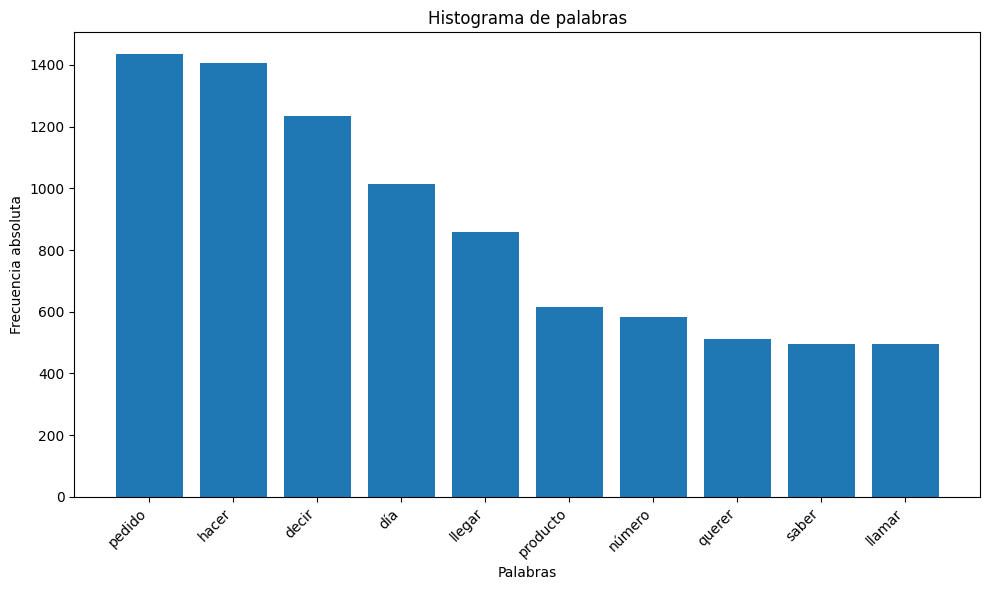

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

limit = 10
all_words = [word for document in doc_clean for word in document]

word_frequencies = Counter(all_words)

words = list(word_frequencies.keys())
frequencies = list(word_frequencies.values())

sorted_indices = sorted(range(len(frequencies)), key=lambda k: frequencies[k], reverse=True)
words = [words[i] for i in sorted_indices]
frequencies = [frequencies[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(words[0:limit], frequencies[0:limit])
plt.xlabel('Palabras')
plt.ylabel('Frecuencia absoluta')
plt.title('Histograma de palabras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Topic modeling con LDA - modelo base
Se eligió el modelo LDA (Latend Dirichlet Allocation) para modelar los tópicos de cada texto. En primer lugar se entrenó un modelo con los hiperparámetros por defecto con el fin de obtener una performance base, y luego se aplicó tuneo de hiperparámetros para mejorar esa performance.

Hiperparámetros relevantes:
- num_topics: cantidad de tópicos presentes en el corpus
- num_words: cantidad de palabras que forman cada tópico
- passes: la cantidad de iteraciones de entrenamiento del algoritmo LDA
- Alfa: representa la densidad de tópicos en los documentos
- Eta: representa la densidad de palabras en los tópicos

In [18]:
num_topics = 8
num_words = 8
passes = 50

## Train-test split

In [19]:
import random
from sklearn.model_selection import train_test_split

train_prop = 0.9 #90% para train, 10% para test
doc_train, doc_test = train_test_split(doc_clean, test_size=1 - train_prop, random_state=42)
print(len(doc_train),len(doc_test))

576 64


## Generar matriz Document-Term
Esta matriz resume la frecuencia de aparición de cada término en cada documento. Es una implementación del concepto de Bag of Words (BoW)

In [20]:
import gensim
from gensim import corpora

# Crear el diccionario de términos del corpus
dictionary = corpora.Dictionary(doc_clean)

# Convertir el corpus en la matrix document-term
corpus_train = [dictionary.doc2bow(doc) for doc in doc_train]
corpus_test = [dictionary.doc2bow(doc) for doc in doc_test]


## Entrenamiento del modelo

In [21]:
# Crear objeto lda usando gensim
Lda = gensim.models.ldamodel.LdaModel

# Correr y entrenar el modelo LDA sobre la matriz
ldamodel = Lda(corpus_train, num_topics=num_topics, id2word = dictionary, passes=passes)

## Resultados de la inferencia

In [22]:
topics = ldamodel.print_topics(num_topics=num_topics, num_words=num_words)
topic_labels = {}

# Recorrer cada tópico y asignar un label basado en las palabras más relevantes
for topic_index, topic in enumerate(topics):
    words = [word.split("*")[1].strip() for word in topic[1].split(" + ")]
    label = f"Topic {topic_index + 1}: {' '.join(words)}"
    topic_labels[topic_index] = label

for topic_index, label in topic_labels.items():
    print(label)

Topic 1: "producto" "hacer" "día" "decir" "querer" "perfecto" "saber" "color"
Topic 2: "pedido" "querer" "decir" "hacer" "nombre" "saber" "número" "gracia"
Topic 3: "realizar" "caso" "lista" "día" "seleccionar" "indicar" "modo" "guardar"
Topic 4: "unidad" "decir" "gramo" "kilo" "faltar" "azúcar" "cosa" "punto"
Topic 5: "correcto" "producto" "unidad" "venta" "quiero" "lunes" "dirección" "aplicación"
Topic 6: "venir" "decir" "llegar" "leche" "hacer" "cosa" "dar" "ir"
Topic 7: "producto" "decir" "hacer" "día" "venir" "llegar" "pedido" "cosa"
Topic 8: "pedido" "favor" "número" "día" "producto" "indicar" "momento" "gracia"
Topic 9: "hacer" "tarjeta" "compra" "día" "crédito" "decir" "pedido" "vez"
Topic 10: "cosa" "hamburguesa" "querer" "perfecto" "pedido" "unidad" "gramo" "vacuno"
Topic 11: "código" "aplicación" "venir" "ingresar él" "amable" "hablar" "saber" "natural"
Topic 12: "hacer" "pedido" "decir" "llegar" "día" "ver" "correo" "bueno"
Topic 13: "decir" "hacer" "llegar" "día" "pedido" 

#### Set de train

In [23]:
# Para cada documento, determinar el tópico con mayor probabilidad
for i, document in enumerate(corpus_train):
    topic_distribution = ldamodel.get_document_topics(document)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    print(f"Doc {i + 1}: {topic_labels[dominant_topic[0]]} Prob.: {dominant_topic[1]}")

Doc 1: Topic 1: "producto" "hacer" "día" "decir" "querer" "perfecto" "saber" "color" Prob.: 0.520347535610199
Doc 2: Topic 13: "decir" "hacer" "llegar" "día" "pedido" "saber" "querer" "perfecto" Prob.: 0.8443912267684937
Doc 3: Topic 9: "hacer" "tarjeta" "compra" "día" "crédito" "decir" "pedido" "vez" Prob.: 0.512252926826477
Doc 4: Topic 8: "pedido" "favor" "número" "día" "producto" "indicar" "momento" "gracia" Prob.: 0.7140525579452515
Doc 5: Topic 8: "pedido" "favor" "número" "día" "producto" "indicar" "momento" "gracia" Prob.: 0.9820494651794434
Doc 6: Topic 12: "hacer" "pedido" "decir" "llegar" "día" "ver" "correo" "bueno" Prob.: 0.8969895243644714
Doc 7: Topic 12: "hacer" "pedido" "decir" "llegar" "día" "ver" "correo" "bueno" Prob.: 0.9473811984062195
Doc 8: Topic 2: "pedido" "querer" "decir" "hacer" "nombre" "saber" "número" "gracia" Prob.: 0.6749045252799988
Doc 9: Topic 8: "pedido" "favor" "número" "día" "producto" "indicar" "momento" "gracia" Prob.: 0.4467504620552063
Doc 10:

#### Set de test

In [24]:
# Para cada documento, determinar el tópico con mayor probabilidad
for i, document in enumerate(corpus_test):
    topic_distribution = ldamodel.get_document_topics(document)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    print(f"Doc {i + 1}: {topic_labels[dominant_topic[0]]} Prob.: {dominant_topic[1]}")

Doc 1: Topic 12: "hacer" "pedido" "decir" "llegar" "día" "ver" "correo" "bueno" Prob.: 0.5714004039764404
Doc 2: Topic 12: "hacer" "pedido" "decir" "llegar" "día" "ver" "correo" "bueno" Prob.: 0.8820182681083679
Doc 3: Topic 12: "hacer" "pedido" "decir" "llegar" "día" "ver" "correo" "bueno" Prob.: 0.6613786816596985
Doc 4: Topic 13: "decir" "hacer" "llegar" "día" "pedido" "saber" "querer" "perfecto" Prob.: 0.5256640911102295
Doc 5: Topic 13: "decir" "hacer" "llegar" "día" "pedido" "saber" "querer" "perfecto" Prob.: 0.5369067192077637
Doc 6: Topic 12: "hacer" "pedido" "decir" "llegar" "día" "ver" "correo" "bueno" Prob.: 0.6247714161872864
Doc 7: Topic 9: "hacer" "tarjeta" "compra" "día" "crédito" "decir" "pedido" "vez" Prob.: 0.44163981080055237
Doc 8: Topic 9: "hacer" "tarjeta" "compra" "día" "crédito" "decir" "pedido" "vez" Prob.: 0.5759011507034302
Doc 9: Topic 12: "hacer" "pedido" "decir" "llegar" "día" "ver" "correo" "bueno" Prob.: 0.5224615335464478
Doc 10: Topic 13: "decir" "hace

### Cuantificación del modelo base - coherencia
Son una serie de métricas que determinan el grado de coherencia entre las palabras que forman un mismo tópico. Idealmente, se buscan tópicos con la mayor coherencia posible. En este caso uso la métrica c_v

In [25]:
from gensim.models import CoherenceModel

# Calculara Coherencia
coherence_model_lda = CoherenceModel(model=ldamodel, texts=doc_train,dictionary=dictionary,coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.30706307347188416


La performance base es de *c_v* = 0.30706307347188416




# Tuneo de hiperparámetros
El hiperparámetro más relevante a tunear es el Número de tópicos (K).

Para la comparación de los distintos modelos se usará la métrica *c_v*
Se utiliza la técnica de grid search, estableciendo una grilla de valores para cada hiperparámetro (en este caso uno solo) y probando todas las combinaciones de los mismos, buscando la que maximiza la métrica de interés.

El mismo proceso podría repetirse para más hiperparámetros, como podrían ser alfa y eta de LDA, o el número de iteraciones, teniendo en cuenta el aumento en tiempo de ejecución que conlleva.

In [83]:
def compute_coherence_values(corpus,dictionary, k):

    lda_model_coh = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=100,
                                           passes=passes,
                                           )

    coherence_model_lda = CoherenceModel(model=lda_model_coh, texts=doc_train,dictionary=dictionary, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [84]:
import numpy as np
import tqdm
import pandas as pd

# Topics range
min_topics = 2
max_topics = 30
step_size = 2
topics_range = range(min_topics, max_topics, step_size)

model_results = {
                 'Topics': [],
                 'Coherence': []
                }

pbar = tqdm.tqdm(total=(len(topics_range)))

for k in topics_range:
      cv = compute_coherence_values(corpus=corpus_train, dictionary=dictionary, k=k)
      model_results['Topics'].append(k)
      model_results['Coherence'].append(cv)

      pbar.update(1)
pd.DataFrame(model_results).to_csv('./results/lda_hyp_tuning_results.csv', index=False)
pbar.close()

100%|██████████| 14/14 [05:35<00:00, 23.98s/it]


In [85]:
model_results.keys()

dict_keys(['Topics', 'Coherence'])

In [86]:
import pandas as pd
model_results = pd.read_csv('./results/lda_hyp_tuning_results.csv')
model_results


,Topics,Coherence
0,2,0.358894
1,4,0.346525
2,6,0.377076
3,8,0.450189
4,10,0.397513
5,12,0.412382
6,14,0.462115
7,16,0.428329
8,18,0.402964
9,20,0.425219


In [87]:
max_coh = model_results['Coherence'].max()
print("Coherencia máxima:",max_coh)

max_coh_idx = model_results['Coherence'].idxmax()
max_coh_row = model_results.loc[max_coh_idx]
print("La coherencia máxima se alcanza con num_topics = ",max_coh_row)

Coherencia máxima: 0.4621147282493436
La coherencia máxima se alcanza con hiperparámetros:  Topics       14.000000
Coherence     0.462115
Name: 6, dtype: float64


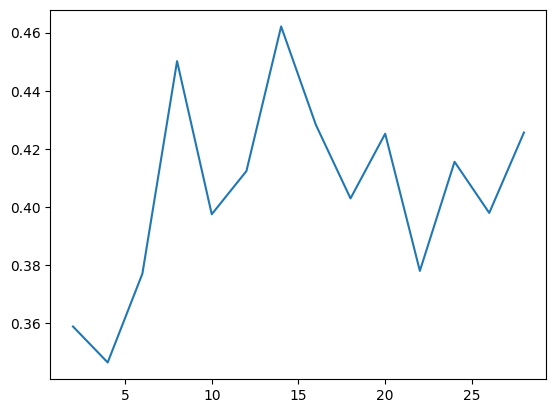

In [90]:
plt.plot(topics_range,model_results['Coherence'])
plt.show()

### Entrenamiento del modelo final

A partir del análisis de la métrica de coherencia c_v, se concluye que el valor de número de tópicos que maximiza c_v es:
1.   número de tópicos = 14

Con estos valores se entrena un nuevo modelo



In [91]:
num_topics = max_coh_row['Topics']

lda_model_tuned = gensim.models.LdaMulticore(corpus=corpus_train,
                                           id2word=dictionary,
                                           num_topics=num_topics
                                           passes=50)

In [92]:
topics = lda_model_tuned.print_topics(num_topics=num_topics, num_words=num_words)
topic_labels = {}

# Recorrer cada tópico y asignar un label basado en las palabras más relevantes
for topic_index, topic in enumerate(topics):
    words = [word.split("*")[1].strip() for word in topic[1].split(" + ")]
    label = f"Topic {topic_index + 1}: {' '.join(words)}"
    topic_labels[topic_index] = label

for topic_index, label in topic_labels.items():
    print(label)

Topic 1: "pedido" "día" "número" "perfecto" "favor" "gusto" "buena" "gracia"
Topic 2: "hacer" "tarjeta" "compra" "decir" "cargo" "querer" "pedido" "gracia"
Topic 3: "pedido" "día" "favor" "hacer" "número" "producto" "indicar" "correcto"
Topic 4: "kilo" "tener" "pegado" "punto" "hacer" "clave" "correo" "azúcar"
Topic 5: "persona" "bueno" "consuelo" "robo" "francesca" "francés" "gracia" "gracias"
Topic 6: "decir" "tarjeta" "hacer" "querer" "cobrar" "salir" "cosa" "número"
Topic 7: "correo" "unidad" "venir" "hacer" "cosa" "gramo" "bueno" "pedido"
Topic 8: "decir" "pedido" "hacer" "día" "carro" "ir" "caso" "realizar"
Topic 9: "decir" "llegar" "hacer" "pedido" "día" "saber" "producto" "cosa"
Topic 10: "llegar" "decir" "poner" "dirección" "pedido" "hacer" "día" "saber"
Topic 11: "alar" "decir" "correo" "hacer" "pedido" "llamar" "llegar" "aló"
Topic 12: "hacer" "crédito" "tarjeta" "decir" "compra" "tarjeto" "vez" "cobro"
Topic 13: "pedido" "día" "llegar" "hacer" "decir" "querer" "pasar" "llam

### Inferencia en set de *train*

In [93]:
# Para cada documento, determinar el tópico con mayor probabilidad
for i, document in enumerate(corpus_train):
    topic_distribution = lda_model_tuned.get_document_topics(document)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    print(f"Doc {i + 1}: {topic_labels[dominant_topic[0]]} Prob.: {dominant_topic[1]}")

Doc 1: Topic 13: "pedido" "día" "llegar" "hacer" "decir" "querer" "pasar" "llamar" Prob.: 0.6595581769943237
Doc 2: Topic 10: "llegar" "decir" "poner" "dirección" "pedido" "hacer" "día" "saber" Prob.: 0.8452203273773193
Doc 3: Topic 14: "decir" "pedido" "hacer" "ver" "compra" "querer" "claro" "tarjeta" Prob.: 0.9960471391677856
Doc 4: Topic 3: "pedido" "día" "favor" "hacer" "número" "producto" "indicar" "correcto" Prob.: 0.7437434196472168
Doc 5: Topic 1: "pedido" "día" "número" "perfecto" "favor" "gusto" "buena" "gracia" Prob.: 0.43622082471847534
Doc 6: Topic 13: "pedido" "día" "llegar" "hacer" "decir" "querer" "pasar" "llamar" Prob.: 0.6146190762519836
Doc 7: Topic 14: "decir" "pedido" "hacer" "ver" "compra" "querer" "claro" "tarjeta" Prob.: 0.9954469203948975
Doc 8: Topic 14: "decir" "pedido" "hacer" "ver" "compra" "querer" "claro" "tarjeta" Prob.: 0.8280242681503296
Doc 9: Topic 3: "pedido" "día" "favor" "hacer" "número" "producto" "indicar" "correcto" Prob.: 0.3512042164802551
Do

### Inferencia en set de *test*

In [94]:
# Para cada documento, determinar el tópico con mayor probabilidad
for i, document in enumerate(corpus_test):
    topic_distribution = lda_model_tuned.get_document_topics(document)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    print(f"Doc {i + 1}: {topic_labels[dominant_topic[0]]} Prob.: {dominant_topic[1]}")

Doc 1: Topic 9: "decir" "llegar" "hacer" "pedido" "día" "saber" "producto" "cosa" Prob.: 0.3245479464530945
Doc 2: Topic 14: "decir" "pedido" "hacer" "ver" "compra" "querer" "claro" "tarjeta" Prob.: 0.43987032771110535
Doc 3: Topic 14: "decir" "pedido" "hacer" "ver" "compra" "querer" "claro" "tarjeta" Prob.: 0.47423428297042847
Doc 4: Topic 13: "pedido" "día" "llegar" "hacer" "decir" "querer" "pasar" "llamar" Prob.: 0.8362302184104919
Doc 5: Topic 9: "decir" "llegar" "hacer" "pedido" "día" "saber" "producto" "cosa" Prob.: 0.604071855545044
Doc 6: Topic 14: "decir" "pedido" "hacer" "ver" "compra" "querer" "claro" "tarjeta" Prob.: 0.7988569140434265
Doc 7: Topic 14: "decir" "pedido" "hacer" "ver" "compra" "querer" "claro" "tarjeta" Prob.: 0.5501081347465515
Doc 8: Topic 13: "pedido" "día" "llegar" "hacer" "decir" "querer" "pasar" "llamar" Prob.: 0.9285702109336853
Doc 9: Topic 9: "decir" "llegar" "hacer" "pedido" "día" "saber" "producto" "cosa" Prob.: 0.4500403106212616
Doc 10: Topic 13:

### Interpretación mediante pyLDAvis
Esta librería provee una forma visual de analizar la relación entre los tópicos hallados, como por ejemplo la distancia (en un espacio bidimensional) y la importancia de cada uno dentro del corpus (según el tamaño del círculo)

In [95]:
!pip install pyldavis
!pip install pandas==1.5.3 #Esta versión es necesaria para pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis

  Using cached pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.17.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.4 which is incompatible.
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: p

In [96]:
lda_data = pyLDAvis.gensim_models.prepare(lda_model_tuned, corpus_train, dictionary)
pyLDAvis.display(lda_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


# Posibles mejoras a futuro

- Tuneo de hiperparámetros de LDA:
  - El más relevante es el número de tópicos. No hay reglas definidas de cómo elegirlo, ya que depende mucho de las características del corpus. Lo ideal es realizar varios experimentos, calculando la métrica elegida, y elegir el valor de num_topics más adecuado. Importante destacar que podría elegirse otra métrica, aquí trabajé solamente con *c_v* para no extender demasiado el código.
  - Mejorar la búsqueda del K óptimo: existen algoritmos especialmente diseñados para este problema
  - el número de iteraciones también es relevante. Un número mayor puede dar mejores resultados, pero a su vez conlleva un mayor tiempo de ejecución.
- Probar otras técnicas de tokenización y preprocesamiento.
- Probar otros algoritmos de modelado de tópicos.
